In [22]:
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [9]:

def read_imdb_data(data_dir="data/imdb-reviews/"):
    
    data = {}
    labels = {}
    
    # need to return nested dicts above in directory structure
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        # Two directories for label : {pos, neg}
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f, encoding='utf-8') as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), "{}/{} data size does not match label size".format(data_type, sentiment)
    
    return data, labels

data, labels = read_imdb_data()
print("IMBD reviews: train = {} pos/ {} neg, test = {} pos/ {} neg".format(data['train']['pos'],
                                                                           data['train']['neg'],
                                                                           data['test']['pos'],
                                                                           data['test']['neg']
                                                                          ))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
print(data['train']['pos'][2])

Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scenes in clothes warehouse are second to none. The corn on face is a classic, as good as anything in Blazing Saddles. The take on lawyers is also superb. After being accused of being a turncoat, selling out his boss, and being dishonest the lawyer of Pepto Bolt shrugs indifferently "I'm a lawyer" he says. Three funny words. Jeffrey Tambor, a favorite from the later Larry Sanders show, is fantastic here too as a mad millionaire who wants to crush the ghetto. His character is more malevolent than usual. The hospital scene, and the scene where the homeless invade a demolition site, are all-time classics. Look for the legs scene and the two big diggers fighting (one bleeds). This movie gets better each time I see it (which is quite often).


In [11]:
print(data['train']['neg'][2])

This film lacked something I couldn't put my finger on at first: charisma on the part of the leading actress. This inevitably translated to lack of chemistry when she shared the screen with her leading man. Even the romantic scenes came across as being merely the actors at play. It could very well have been the director who miscalculated what he needed from the actors. I just don't know.<br /><br />But could it have been the screenplay? Just exactly who was the chef in love with? He seemed more enamored of his culinary skills and restaurant, and ultimately of himself and his youthful exploits, than of anybody or anything else. He never convinced me he was in love with the princess.<br /><br />I was disappointed in this movie. But, don't forget it was nominated for an Oscar, so judge for yourself.


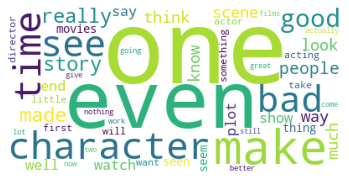

In [12]:


from wordcloud import WordCloud, STOPWORDS
sentiment = 'neg'

combined_text = "".join([review for review in data['train'][sentiment]])

wc = WordCloud(background_color='white', max_words=50, stopwords= STOPWORDS.update(['br', 'film', 'movie']))

plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

In [13]:


def prepare_imdb_data(data):
    train_X = data['train']['pos'] + (data['train']['neg'])
    train_Y = (['pos']*len(data['train']['pos'])) + (['neg']*len(data['train']['neg']))
    test_X = data['test']['pos'] + (data['test']['neg'])
    test_Y = (['pos']*len(data['test']['pos'])) + (['neg']*len(data['test']['neg']))
    
    data_train, labels_train = shuffle(train_X, train_Y)
    data_test, labels_test = shuffle(test_X, test_Y)
    return data_train, data_test, labels_train, labels_test

data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


In [2]:
from bs4 import BeautifulSoup
import re
import nltk
nltk.data.path.append('../../../../Python Libs/')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()

In [15]:
def review_to_words(review):
    soup = BeautifulSoup(review)
    non_html_text = soup.get_text()
    exp = re.compile(r'[^a-zA-Z\s]')
    alphabet_text = exp.sub(' ', non_html_text)
    lowercase_text = alphabet_text.lower()
    tokenized_text = word_tokenize(lowercase_text)
    stopword_clean_text = [w for w in tokenized_text if w not in stopwords.words('english')]
    stemmed_words = [stemmer.stem(w) for w in stopword_clean_text]
    
    return stemmed_words

review_to_words("""This is just a <em>test</em>.<br/><br />But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

In [24]:
import pickle

cache_dir = os.path.join("cache","sentiment_analysis")
os.makedirs(cache_dir, exist_ok=True)  # If cache exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file)) as f:
                cache_data = pickle.load(f)
            print("Reading preprocessed data from {}".format(cache_file))
        except:
            pass
    
    if cache_data is None:
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        if cache_file is not None:
            cache_data = dict(words_train = words_train, words_test = words_test,
                              labels_train = labels_train, labels_test = labels_test)
            with(open(os.path.join(cache_dir, cache_file), "wb")) as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return  words_train, words_test, labels_train, labels_test

In [17]:
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Wrote preprocessed data to cache file: preprocessed_data.pkl

--- Raw review ---
Master director Ching Siu Tung's perhaps most popular achievement is this series, A Chinese Ghost Story 1-3. Chinese Ghost Story stars Leslie Cheung in some distant past in China as a tax collector who is forced to spend a night during his "collecting trip" in a mysterious castle in which some strange old warriors fight and meet him. Beautiful actress Joey Wang/Wong is the ghost who lives in that castle and is under a domination of one powerful demon, a wood devil who collects human souls for herself/itself with the help of her beautiful ghosts. Leslie and Joey fall in love, and even though ghosts are not allowed to live with humans, they decide to break that rule and live happily together for the rest of their lives. This is not what the wood devil thinks and our protagonists have to fight for their lives and their happiness.<br /><br />This film is no less full of magic than other films by Ching Siu Tung

In [41]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # TODO: Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        dummy = lambda x: x
        vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, max_features=vocabulary_size)
        features_train = vectorizer.fit_transform(words_train).toarray()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary



# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['brilliantli', 'contain', 'trap', 'flirt', 'kurt', 'left', 'indulg', 'yellow']

--- Preprocessed words ---
['base', 'comic', 'book', 'video', 'game', 'draw', 'year', 'old', 'noth', 'movi', 'taken', 'serious', 'charact', 'dialog', 'plot', 'action', 'noth', 'high', 'tech', 'intern', 'terrorist', 'crimin', 'bicker', 'like', 'pre', 'school', 'kid', 'stallon', 'man', 'steel', 'type', 'resili', 'toward', 'ice', 'cold', 'weather', 'dialog', 'dumb', 'sometim', 'almost', 'hilari', 'even', 'codenam', 'bad', 'guy', 'use', 'dumb', 'tango', 'tango', 'film', 'entertain', 'suspens', 'good', 'action', 'sequenc', 'nice', 'snowi', 'mountain', 'set', 'oh', 'ye', 'unintent', 'humour', 'film', 'open', 'truli', 'bad', 'unconvinc', 'gay', 'banter', 'go', 'lucki', 'happi', 'charact', 'obvious', 'swell', 'time', 'come', 'sweat', 'induc', 'fail', 'rescu', 'part', 'make', 'anyon', 'fear', 'height', 'problem', 'want', 'pull', 'ha

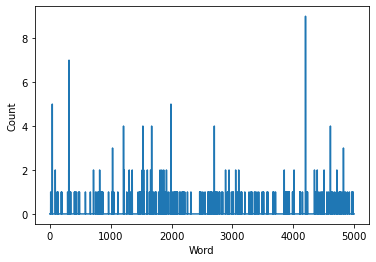

In [42]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [54]:
sparsity_sum = 0
for i in range(len(features_train)):
    sparsity_sum += len([x for x in features_train[i, :] == 0 if x])/5000
print(sparsity_sum/len(features_train))

0.983267224000016


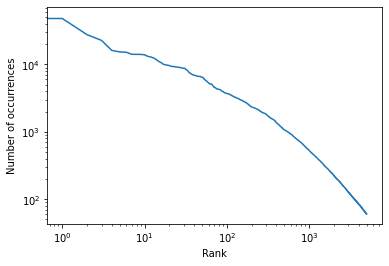

In [52]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [57]:
#Most frequent word , second most frequent
sorted_word_freq[0], sorted_word_freq[1], sorted_word_freq[2]
#Not floowing as doc is preprocessed and common words already removed as stopwords

(51696, 48191, 27742)

In [60]:
import sklearn.preprocessing as pr

features_train_normalized = pr.normalize(features_train)
features_test_normalized = pr.normalize(features_test)

In [67]:
from sklearn.naive_bayes import GaussianNB

# TODO: Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train_normalized, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.83064, test = 0.74648


In [80]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
tuned_params = [{'n_estimators' : [1, 10, 20, 30, 40, 50], 'learning_rate': [1.0], 'max_depth':[1], 'random_state':[0]}]

clf = GridSearchCV(
    GradientBoostingClassifier(), tuned_params, scoring='accuracy'
)
clf.fit(features_train_normalized, labels_train)
print(clf.best_params_)


{'learning_rate': 1.0, 'max_depth': 1, 'n_estimators': 50, 'random_state': 0}


In [82]:

n_estimators = 81

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)
    clf.fit(X_train, y_train)
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

0.83352
0.82848


In [1]:
from tensorflow.keras.datasets import imdb

vocabulary_size = 5000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)

print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
S:\Software\Installation\Anaconda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


Loaded dataset with 25000 training samples, 25000 test samples


S:\Software\Installation\Anaconda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [2]:
# Inspect a sample review and its label
print("--- Review ---")
print(X_train[7])
print("--- Label ---")
print(y_train[7])

--- Review ---
[1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2, 2, 2, 4, 2, 628, 2, 37, 9, 150, 4, 2, 4069, 11, 2909, 4, 2, 847, 313, 6, 176, 2, 9, 2, 138, 9, 4434, 19, 4, 96, 183, 26, 4, 192, 15, 27, 2, 799, 2, 2, 588, 84, 11, 4, 3231, 152, 339, 2, 42, 4869, 2, 2, 345, 4804, 2, 142, 43, 218, 208, 54, 29, 853, 659, 46, 4, 882, 183, 80, 115, 30, 4, 172, 174, 10, 10, 1001, 398, 1001, 1055, 526, 34, 3717, 2, 2, 2, 17, 4, 2, 1094, 871, 64, 85, 22, 2030, 1109, 38, 230, 9, 4, 4324, 2, 251, 2, 1034, 195, 301, 14, 16, 31, 7, 4, 2, 8, 783, 2, 33, 4, 2945, 103, 465, 2, 42, 845, 45, 446, 11, 1895, 19, 184, 76, 32, 4, 2, 207, 110, 13, 197, 4, 2, 16, 601, 964, 2152, 595, 13, 258, 4, 1730, 66, 338, 55, 2, 4, 550, 728, 65, 1196, 8, 1839, 61, 1546, 42, 2, 61, 602, 120, 45, 2, 6, 320, 786, 99, 196, 2, 786, 2, 4, 225, 4, 373, 1009, 33, 4, 130, 63, 69, 72, 1104, 46, 1292, 225, 14, 66, 194, 2, 1703, 56, 8, 803, 1004, 6, 2, 155, 11, 4, 2, 3231, 45, 853, 2029, 8, 30, 6, 117, 430

In [3]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[7]])
print("--- Label ---")
print(y_train[7])

--- Review (with words) ---
['the', 'of', 'and', 'local', 'of', 'their', 'br', 'of', 'attention', 'widow', 'and', 'captures', 'parties', 'and', 'and', 'and', 'and', 'excitement', 'and', 'and', 'and', 'and', 'of', 'and', 'english', 'and', 'like', 'it', 'years', 'of', 'and', 'unintentional', 'this', 'hitchcock', 'of', 'and', 'learn', 'everyone', 'is', 'quite', 'and', 'it', 'and', 'such', 'it', 'bonus', 'film', 'of', 'too', 'seems', 'he', 'of', 'enough', 'for', 'be', 'and', 'editing', 'and', 'and', 'please', 'great', 'this', 'of', 'shoots', 'thing', '3', 'and', "it's", 'mentioning', 'and', 'and', 'given', 'parties', 'and', 'back', 'out', 'interesting', 'times', 'no', 'all', 'average', 'talking', 'some', 'of', 'nor', 'seems', 'into', 'best', 'at', 'of', 'every', 'cast', 'i', 'i', 'inside', 'keep', 'inside', 'large', 'viewer', 'who', 'obscure', 'and', 'and', 'and', 'movie', 'of', 'and', 'entirely', "you've", 'see', 'because', 'you', 'deals', 'successful', 'her', 'anything', 'it', 'of', 'ded

In [4]:
max([len(x) for x in X_train])

2494

In [5]:
min([len(x) for x in X_train])

11

In [18]:
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
# Set the maximum number of words per document (for both training and testing)
max_words = 500
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_words)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_words)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=128, input_length=500))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 128)          640000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 771,713
Trainable params: 771,713
Non-trainable params: 0
_________________________________________________________________


In [11]:
len(X_train_pad[1])

500

In [20]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
batch_size = 1024
num_epochs = 10

validation_split = 0.15
model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=validation_split, verbose=1)

Epoch 1/10
21/21 [==============================] - 10s 421ms/step - loss: 0.6780 - accuracy: 0.6357 - val_loss: 0.6299 - val_accuracy: 0.7416
Epoch 2/10
21/21 [==============================] - 8s 390ms/step - loss: 0.5312 - accuracy: 0.7903 - val_loss: 0.4267 - val_accuracy: 0.8248
Epoch 3/10
21/21 [==============================] - 8s 388ms/step - loss: 0.3491 - accuracy: 0.8582 - val_loss: 0.3413 - val_accuracy: 0.8576
Epoch 4/10
21/21 [==============================] - 8s 390ms/step - loss: 0.2637 - accuracy: 0.8968 - val_loss: 0.3101 - val_accuracy: 0.8763
Epoch 5/10
21/21 [==============================] - 8s 391ms/step - loss: 0.2211 - accuracy: 0.9186 - val_loss: 0.3211 - val_accuracy: 0.8813
Epoch 6/10
21/21 [==============================] - 8s 390ms/step - loss: 0.1948 - accuracy: 0.9298 - val_loss: 0.3184 - val_accuracy: 0.8827
Epoch 7/10
21/21 [==============================] - 8s 390ms/step - loss: 0.1683 - accuracy: 0.9417 - val_loss: 0.3457 - val_accuracy: 0.8725
Epoch

In [25]:
# Save your model, so that you can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

# Later you can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))

In [27]:
# Evaluate your model on the test set
scores = model.evaluate(X_test_pad, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.8669999837875366
